In [1]:
import numpy as np
import pandas as pd
import TAF
import datetime
import talib 

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
%matplotlib inline

import seaborn as sns
sns.set_style('white')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [2]:
factors = pd.read_csv('HS300_15m.csv')

index = factors['index']
High = factors.high.values
Low = factors.low.values
Close = factors.close.values
Open = factors.open.values
Volume = factors.volume.values

factors = TAF.get_factors(index, Open, Close, High, Low, Volume, drop=True)

factors = factors.iloc[-700 * 16 - 11 * 16:]

In [3]:
start_date = factors.index[11*16][:10]
end_date = factors.index[-1][:10]

print ('开始时间', start_date)
print ('结束时间', end_date)

开始时间 2014-02-25
结束时间 2016-12-30


In [4]:
rolling = 88

targets = pd.read_csv('HS300_1d.csv')
targets.rename(columns={'Unnamed: 0':'tradeDate'}, inplace=True)
targets['returns'] = targets.close.shift(-5)/ targets.close - 1.

targets.set_index('tradeDate', inplace=True)
targets= targets.loc[start_date:end_date, 'returns']

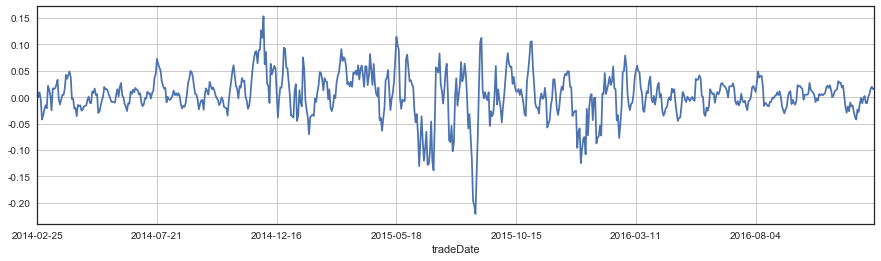

In [5]:
targets.plot(figsize=(15,4))
plt.grid()
#plt.savefig(u'fig11.png',dpi=100,frameon=False)

#### 输入数据

In [6]:
inputs = np.array(factors).reshape(-1, 1, 58)

targets = np.expand_dims(targets, axis=1)
targets = np.expand_dims(targets, axis=1)

train_inputs = inputs[:-100*16]
test_inputs = inputs[-100*16 - 11 * 16:]

train_targets = targets[:-100]
test_targets = targets[-100:]

train_gather_list = np.arange(train_inputs.shape[0])
train_gather_list = train_gather_list.reshape([-1,16])[11:]
train_gather_list = train_gather_list[:,-1]

test_gather_list = np.arange(test_inputs.shape[0])
test_gather_list = test_gather_list.reshape([-1,16])[11:]
test_gather_list = test_gather_list[:,-1]

#### 无tanh

In [7]:
import tensorflow as tf
from DNCore import DNCore_L1

class Regression_DNC_BasicLSTM_L1(object):
    """
    """
    
    def __init__(self, 
                 inputs, 
                 targets,
                 gather_list=None,
                 batch_size=1, 
                 hidden_size=100, 
                 memory_size=100, 
                 num_reads=3,
                 num_writes=1):
        
        # 控制参数
        self._tmp_inputs = inputs
        self._tmp_targets = targets
        self._in_length = None
        self._in_width = inputs.shape[2]
        self._out_length = None
        self._out_width = targets.shape[2]
        self._batch_size = batch_size
        
        #
        self._sess = tf.InteractiveSession()
        # 声明变量
        self._inputs = tf.placeholder(dtype=tf.float32, 
                                      shape=[self._in_length, self._batch_size, self._in_width], 
                                      name='inputs')
        self._targets = tf.placeholder(dtype=tf.float32, 
                                       shape=[self._out_length, self._batch_size, self._out_width],
                                       name='targets')
        
        self._InferenceCell = DNCore_L1(
            dnc_output_size=self._out_width, 
            hidden_size=hidden_size, 
            memory_size=memory_size, 
            word_size=self._in_width, 
            num_read_heads=num_reads,
            num_write_heads=num_writes)
        
        self._initial_state = \
        self._InferenceCell.initial_state(batch_size)
        
        output_sequences, _ = \
        tf.nn.dynamic_rnn(cell= self._InferenceCell, 
                          inputs=self._inputs, 
                          initial_state=self._initial_state, 
                          time_major=True)
        
        self._pred_outputs = output_sequences
        
        if gather_list is not None:
            output_sequences = tf.gather(output_sequences, gather_list)
            
        #output_sequences = tf.tanh(output_sequences)       
        cost = tf.square(output_sequences-self._targets)
        self._cost = tf.reduce_mean(cost)
        
    def fit(self, 
            training_iters =1e2,             
            learning_rate = 1e-4,
            optimizer_epsilon = 1e-10,
            max_gard_norm = 50):

        # Set up optimizer with global norm clipping.
        trainable_variables = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(
            tf.gradients(self._cost, trainable_variables), max_gard_norm)
        global_step = tf.get_variable(
            name="global_step",
            shape=[],
            dtype=tf.int64,
            initializer=tf.zeros_initializer(),
            trainable=False,
            collections=[tf.GraphKeys.GLOBAL_VARIABLES, tf.GraphKeys.GLOBAL_STEP])
        
        optimizer = tf.train.RMSPropOptimizer(
            learning_rate=learning_rate, epsilon=optimizer_epsilon)
        self._train_step = optimizer.apply_gradients(
            zip(grads, trainable_variables), global_step=global_step)  
        
        self._sess.run(tf.global_variables_initializer())
        for scope in range(np.int(training_iters)):
            _, loss = self._sess.run([self._train_step, self._cost], 
                                     feed_dict = {self._inputs:self._tmp_inputs, self._targets:self._tmp_targets})
            print (scope, '---', loss)
            
            
    def close(self):
        self._sess.close()
        print ('结束进程，清理tensorflow内存/显存占用')
            
    def pred(self, 
             inputs,
             gather_list=None):
        
        output_pred = self._pred_outputs
        if gather_list is not None:
            output_pred = tf.gather(output_pred, gather_list)
            
        #outputs = tf.tanh(output_pred)
        outputs = output_pred
        return self._sess.run(outputs, feed_dict = {self._inputs:inputs})

In [8]:
a = Regression_DNC_BasicLSTM_L1(train_inputs, train_targets, train_gather_list)
a.fit(training_iters = 500, learning_rate=1e-3)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0 --- 0.0143589
1 --- 0.0142677
2 --- 0.014176
3 --- 0.014082
4 --- 0.0139869
5 --- 0.0138865
6 --- 0.0137855
7 --- 0.0136768
8 --- 0.0135697
9 --- 0.0134593
10 --- 0.0133467
11 --- 0.0132293
12 --- 0.0131147
13 --- 0.012991
14 --- 0.0128689
15 --- 0.0127463
16 --- 0.0126181
17 --- 0.0124928
18 --- 0.012363
19 --- 0.012233
20 --- 0.0121014
21 --- 0.0119713
22 --- 0.0118376
23 --- 0.0117045
24 --- 0.0115735
25 --- 0.0114391
26 --- 0.0113064
27 --- 0.0111713
28 --- 0.0110413
29 --- 0.01091
30 --- 0.0107792
31 --- 0.0106505
32 --- 0.0105207
33 --- 0.0103943
34 --- 0.0102671
35 --- 0.0101411
36 --- 0.0100155
37 --- 0.00989134
38 --- 0.00976645
39 --- 0.00964178
40 --- 0.00952046
41 --- 0.00939812
42 --- 0.00927623
43 --- 0.00915132
44 --- 0.009029
45 --- 0.00890498
46 --- 0.00877886
47 --- 0.00865216
48 --- 0.00852583
49 --- 0.00839459
50 --- 0.00826576
51 --- 0.00813343
52 --- 0.0079994
53 --- 0.00786599
54 --- 0.00772888
55 --- 0.00758986
56 --- 0.00745076
57 --- 0.00730953
58 --- 0.0071

436 --- 0.000584573
437 --- 0.000415165
438 --- 0.000346357
439 --- 0.000396127
440 --- 0.000287578
441 --- 0.000279483
442 --- 0.000260547
443 --- 0.000309429
444 --- 0.000407758
445 --- 0.000578205
446 --- 0.000739057
447 --- 0.000767356
448 --- 0.000581956
449 --- 0.000388232
450 --- 0.000309428
451 --- 0.000285362
452 --- 0.000298652
453 --- 0.00037016
454 --- 0.000424207
455 --- 0.000408863
456 --- 0.000333874
457 --- 0.000285332
458 --- 0.000258165
459 --- 0.000283493
460 --- 0.000315005
461 --- 0.000303879
462 --- 0.000291639
463 --- 0.000284011
464 --- 0.000363295
465 --- 0.000344606
466 --- 0.000471417
467 --- 0.000712287
468 --- 0.000689553
469 --- 0.00048462
470 --- 0.000267968
471 --- 0.000163894
472 --- 0.000146018
473 --- 0.000192736
474 --- 0.000323569
475 --- 0.000509409
476 --- 0.000640552
477 --- 0.000614518
478 --- 0.000566876
479 --- 0.000432311
480 --- 0.000309408
481 --- 0.000251011
482 --- 0.000255004
483 --- 0.000208412
484 --- 0.000197583
485 --- 0.00025094
486

In [9]:
b = a.pred(train_inputs, train_gather_list)
a.close()

结束进程，清理tensorflow内存/显存占用


#### tanh激活

In [10]:
#import tensorflow as tf
tf.reset_default_graph()
from DNCore import DNCore_L1

class Regression_DNC_BasicLSTM_L1_tanh(object):
    """
    """
    
    def __init__(self, 
                 inputs, 
                 targets,
                 gather_list=None,
                 batch_size=1, 
                 hidden_size=100, 
                 memory_size=100, 
                 num_reads=3,
                 num_writes=1):
        
        # 控制参数
        self._tmp_inputs = inputs
        self._tmp_targets = targets
        self._in_length = None
        self._in_width = inputs.shape[2]
        self._out_length = None
        self._out_width = targets.shape[2]
        self._batch_size = batch_size
        
        #
        self._sess = tf.InteractiveSession()
        # 声明变量
        self._inputs = tf.placeholder(dtype=tf.float32, 
                                      shape=[self._in_length, self._batch_size, self._in_width], 
                                      name='inputs')
        self._targets = tf.placeholder(dtype=tf.float32, 
                                       shape=[self._out_length, self._batch_size, self._out_width],
                                       name='targets')
        
        self._InferenceCell = DNCore_L1(
            dnc_output_size=self._out_width, 
            hidden_size=hidden_size, 
            memory_size=memory_size, 
            word_size=self._in_width, 
            num_read_heads=num_reads,
            num_write_heads=num_writes)
        
        self._initial_state = \
        self._InferenceCell.initial_state(batch_size)
        
        output_sequences, _ = \
        tf.nn.dynamic_rnn(cell= self._InferenceCell, 
                          inputs=self._inputs, 
                          initial_state=self._initial_state, 
                          time_major=True)
        
        self._pred_outputs = output_sequences
        
        if gather_list is not None:
            output_sequences = tf.gather(output_sequences, gather_list)
            
        output_sequences = tf.tanh(output_sequences)       
        cost = tf.square(output_sequences-self._targets)
        self._cost = tf.reduce_mean(cost)
        
    def fit(self, 
            training_iters =1e2,             
            learning_rate = 1e-4,
            optimizer_epsilon = 1e-10,
            max_gard_norm = 50):

        # Set up optimizer with global norm clipping.
        trainable_variables = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(
            tf.gradients(self._cost, trainable_variables), max_gard_norm)
        global_step = tf.get_variable(
            name="global_step",
            shape=[],
            dtype=tf.int64,
            initializer=tf.zeros_initializer(),
            trainable=False,
            collections=[tf.GraphKeys.GLOBAL_VARIABLES, tf.GraphKeys.GLOBAL_STEP])
        
        optimizer = tf.train.RMSPropOptimizer(
            learning_rate=learning_rate, epsilon=optimizer_epsilon)
        self._train_step = optimizer.apply_gradients(
            zip(grads, trainable_variables), global_step=global_step)  
        
        self._sess.run(tf.global_variables_initializer())
        for scope in range(np.int(training_iters)):
            _, loss = self._sess.run([self._train_step, self._cost], 
                                     feed_dict = {self._inputs:self._tmp_inputs, self._targets:self._tmp_targets})
            print (scope, '---', loss)
            
            
    def close(self):
        self._sess.close()
        print ('结束进程，清理tensorflow内存/显存占用')
            
    def pred(self, 
             inputs,
             gather_list=None):
        
        output_pred = self._pred_outputs
        if gather_list is not None:
            output_pred = tf.gather(output_pred, gather_list)
            
        outputs = tf.tanh(output_pred)
        return self._sess.run(outputs, feed_dict = {self._inputs:inputs})

In [11]:
c = Regression_DNC_BasicLSTM_L1_tanh(train_inputs, train_targets, train_gather_list)
c.fit(training_iters = 500, learning_rate=1e-3)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0 --- 0.0159376
1 --- 0.0158
2 --- 0.0156558
3 --- 0.0155084
4 --- 0.0153566
5 --- 0.0151979
6 --- 0.0150347
7 --- 0.0148698
8 --- 0.0146998
9 --- 0.0145263
10 --- 0.0143481
11 --- 0.0141633
12 --- 0.0139779
13 --- 0.0137891
14 --- 0.0135974
15 --- 0.0134028
16 --- 0.0132027
17 --- 0.0130074
18 --- 0.0128075
19 --- 0.0126059
20 --- 0.0124025
21 --- 0.0122011
22 --- 0.0120018
23 --- 0.0118026
24 --- 0.0116036
25 --- 0.0114093
26 --- 0.0112159
27 --- 0.0110239
28 --- 0.0108367
29 --- 0.0106559
30 --- 0.0104786
31 --- 0.0103055
32 --- 0.0101385
33 --- 0.00997412
34 --- 0.00982027
35 --- 0.00967173
36 --- 0.00952601
37 --- 0.00938891
38 --- 0.00925863
39 --- 0.00913284
40 --- 0.00901428
41 --- 0.00890029
42 --- 0.00879093
43 --- 0.00868753
44 --- 0.00858755
45 --- 0.00849153
46 --- 0.00840026
47 --- 0.0083098
48 --- 0.00822463
49 --- 0.00813947
50 --- 0.00805742
51 --- 0.00797669
52 --- 0.00789488
53 --- 0.00781451
54 --- 0.00773436
55 --- 0.00765496
56 --- 0.00757445
57 --- 0.00749288
58 

435 --- 0.000698028
436 --- 0.000529657
437 --- 0.000369617
438 --- 0.000337396
439 --- 0.000338419
440 --- 0.000340252
441 --- 0.000335806
442 --- 0.000312126
443 --- 0.000305099
444 --- 0.000338756
445 --- 0.00043827
446 --- 0.000468232
447 --- 0.000526922
448 --- 0.000558221
449 --- 0.000501288
450 --- 0.000489366
451 --- 0.000341693
452 --- 0.000323759
453 --- 0.000339444
454 --- 0.000387253
455 --- 0.000439562
456 --- 0.000461988
457 --- 0.000444511
458 --- 0.000428169
459 --- 0.000426983
460 --- 0.000391422
461 --- 0.000388545
462 --- 0.000397954
463 --- 0.000406949
464 --- 0.000317962
465 --- 0.000256912
466 --- 0.000204636
467 --- 0.000199298
468 --- 0.000242799
469 --- 0.000275771
470 --- 0.000324203
471 --- 0.000335267
472 --- 0.000336458
473 --- 0.000341924
474 --- 0.000364288
475 --- 0.000397043
476 --- 0.000420781
477 --- 0.000435294
478 --- 0.000423691
479 --- 0.000465418
480 --- 0.000523951
481 --- 0.00066962
482 --- 0.000644362
483 --- 0.000597113
484 --- 0.000404965
48

In [12]:
d = c.pred(train_inputs, train_gather_list)
c.close()

结束进程，清理tensorflow内存/显存占用


In [13]:
tmp = pd.DataFrame([train_targets.flatten(), b.flatten(), d.flatten()]).T

tmp.columns = ['targets','dnc', 'dnc_tanh']

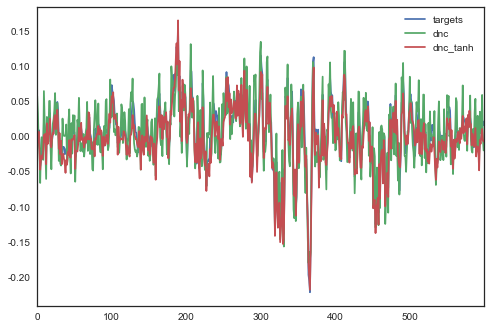

In [14]:
tmp.plot()

In [15]:
tmp.corr()

,targets,dnc,dnc_tanh
targets,1.000000,0.855011,0.955750
dnc,0.855011,1.000000,0.825674
dnc_tanh,0.955750,0.825674,1.000000
